# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"

### 조건
    * ISBN을 고려X, 각각의 리뷰로 보고 테스트

In [20]:
pip list

Package                  Version
------------------------ -------------------
-ip                      20.1.1
absl-py                  0.11.0
appdirs                  1.4.4
argon2-cffi              20.1.0
astor                    0.8.1
astunparse               1.6.3
async-generator          1.10
attrs                    20.3.0
Automat                  20.2.0
backcall                 0.2.0
beautifulsoup4           4.9.3
black                    20.8b1
bleach                   3.3.0
bs4                      0.0.1
cachetools               4.2.1
certifi                  2020.12.5
cffi                     1.14.5
chardet                  4.0.0
click                    7.1.2
cmake                    3.18.4.post1
colorama                 0.4.4
constantly               15.1.0
cryptography             3.4.6
cssselect                1.1.0
cycler                   0.10.0
Cython                   0.29.14
decorator                4.4.2
defusedxml               0.6.0
entrypoints              0.3
flak

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [22]:
import konlpy
from konlpy.tag import Okt

In [23]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [31]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
# 데이터 불러오기
book_data = pd.DataFrame()
df = pd.read_csv('data\detail_bestbook_review.csv', encoding="utf-8")
book_data = pd.concat([book_data,df])

In [26]:
# 코드 확인
print(book_data.head())

          ISBN13  rating                                             review
0  8809474876010      10                배송빠르고..가성비 좋네요.. 진짜 다이어리가 2개가 왔네요 .
1  8809474876010      10  주문한 다음날 오전에 받았어요. 배송 진짜 빠름빠름. 다이어리 대만족! 표지만 살짝...
2  8809474876003      10                             2개 세트는 아니었지만 양장에 퀄리티 굿
3  8809474876003      10  군더더기없이 깔끔하고 하나는 양장이고, 하나는 일반입니다. 2개세트라 내년까지 쓸수...
4  8809474876003      10  깔끔하고 심플하고, A5사이즈로 적당하고 양장인데 잘 펼쳐지고 종이 질도 매끔한거 ...


<AxesSubplot:>

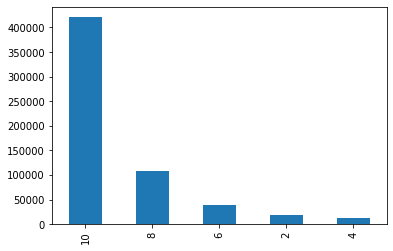

In [27]:
# 점수별 그래프
book_data['rating'].value_counts().plot(kind = 'bar')

## <전처리>

In [38]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

In [16]:
print(type(book_data.iloc[0]['review']))
print(cleansing(str(book_data.iloc[0]['review'])))
print(cleansing(book_data.iloc[0]['review']))
print(cleansing('배송빠르고..가성비 좋네요.. 진짜 다이어리가 2개가 왔네요 .'))

<class 'str'>
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 


In [40]:
# 전처리

book_data.drop_duplicates(subset=["review"], inplace=True)
book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
 # 정규 표현식을 통한 한글 외 문자 제거
book_data["review"] = [cleansing(str(text)) for text in book_data["review"]]
book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# 코드 확인
print(book_data.head())

          ISBN13  rating                                             review
0  8809474876010      10                    배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
1  8809474876010      10  주문한 다음날 오전에 받았어요 배송 진짜 빠름빠름 다이어리 대만족 표지만 살짝 다른...
2  8809474876003      10                             2개 세트는 아니었지만 양장에 퀄리티 굿
3  8809474876003      10  군더더기없이 깔끔하고 하나는 양장이고 하나는 일반입니다 2개세트라 내년까지 쓸수 있...
4  8809474876003      10  깔끔하고 심플하고 A5사이즈로 적당하고 양장인데 잘 펼쳐지고 종이 질도 매끔한거 같...


In [41]:
print('전처리 후 테스트용 샘플의 개수 :',len(book_data))

print(book_data.isnull().values.any())
# book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
# print(book_data.isnull().values.any())

전처리 후 테스트용 샘플의 개수 : 298322
False


In [42]:
print(book_data.isnull().values.any())

False


In [80]:
# 전처리한 리뷰 저장
book_data.to_csv(f'data/detail_bestbook_cleaning.csv', index=False)

d:\project02\field-team4_Test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## <토큰화>

In [43]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '것','라고','에게','라면','게','을','이라','라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있',
             '죠','고','니','로','있','같','어서','어요','는데','습니다','면서']


In [58]:
# 도서 train 데이터 토큰화

okt = Okt()
book_train_X = []

for sentence in book_data['review']:
    temp_X = []
    # temp_X = okt.morphs(sentence, stem=True) # 형태소 단위로 토큰화
    temp_X = okt.nouns(sentence) # 명사 단위로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    # print(temp_X)
    if temp_X : 
        book_train_X.append(temp_X) #빈 list는 추가X

print('END')
print(book_train_X[:50])

END
[['배송', '가성', '비', '진짜', '다이어리', '개'], ['주문', '다음', '날', '오전', '배송', '진짜', '다이어리', '만족', '표지', '살짝', '하나', '더', '권', '세트', '완전', '득템'], ['개', '세트', '양장', '퀄리티', '굿'], ['군더더기', '하나', '양장', '하나', '일반', '개', '세트', '내년', '쿠폰', '무료', '배송'], ['심플', '사이즈', '양장', '종이', '질도', '매', '거', '내년', '거', '보고', '걸', '정착'], ['보고', '작년', '은행', '거', '사용', '내년', '걸', '미리', '구매', '공간', '여유'], ['글씨', '날짜', '표지', '심플', '바'], ['매년', '겨울', '초입', '가계부', '때문', '월간지', '올해', '화장품', '성품', '맘', '처음', '아르고', '나인', '가계부', '구매', '군더더기', '내용', '기입', '란', '가독성', '장점', '무료', '배송', '점', '가장', '결정', '요인', '이구'], ['가계부', '왜', '가요'], ['성인', '이후', '가계부', '처음', '구매', '별로', '고민', '유라', '책', '구매', '구매', '건데', '말', '일단', '앞', '함축', '돈', '대해', '설명', '가계부', '권', '종이', '젤펜', '뒤', '보이', '가계부', '저'], ['편집', '가계부', '김유라', '작가', '별로', '우선', '품목', '금액', '칸', '통장', '자동', '이체', '등등', '정리', '표', '아쉬움', '투성이', '뭔가', '책', '테아블', '색도', '빨강', '색인', '느낌', '다시', '가계부'], ['유튜브', '김유라', '작가', '알', '절약', '방법', '시청', '작가', '가계부', '강조', '저', '가계부', '

In [59]:
# 저장하기
df = pd.DataFrame(book_train_X)
df.to_csv(f'data/detail_bestbook_nouns.csv', index=False)

In [57]:
test = [1]
if test : 
    print("test")
if not test :
    print('not')

test


In [60]:
# 명사 토큰화 데이터 txt로 저장
import pickle

with open('data/detail_bestbook_nouns.txt','wb') as lf :
    pickle.dump(book_train_X,lf)

In [61]:
with open('data/detail_bestbook_nouns.txt', 'rb') as lf:
    readList = pickle.load(lf)
    print(readList[:5])

[['배송', '가성', '비', '진짜', '다이어리', '개'], ['주문', '다음', '날', '오전', '배송', '진짜', '다이어리', '만족', '표지', '살짝', '하나', '더', '권', '세트', '완전', '득템'], ['개', '세트', '양장', '퀄리티', '굿'], ['군더더기', '하나', '양장', '하나', '일반', '개', '세트', '내년', '쿠폰', '무료', '배송'], ['심플', '사이즈', '양장', '종이', '질도', '매', '거', '내년', '거', '보고', '걸', '정착']]


# 정수 인코딩과 단어 집합 만들기

(인코딩값, 빈도수)

In [63]:
from gensim import corpora


dictionary = corpora.Dictionary(book_train_X)
corpus = [dictionary.doc2bow(text) for text in book_train_X]
print(corpus[513]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0

[(2, 1), (3, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [70]:
print(corpus[24838])
print(dictionary[249])
len(dictionary)

[(48, 1), (91, 1), (142, 1), (152, 1), (249, 2), (474, 1), (665, 1), (1039, 1), (1249, 2), (1307, 1), (1811, 1), (1943, 1), (2434, 1), (2809, 1), (5626, 1), (6328, 1), (6483, 1), (7773, 1), (9378, 1), (9379, 1), (9757, 1), (14170, 1), (15858, 1), (15859, 1), (15860, 1), (15861, 2)]
중


54474

# LDA 모델 훈련시키기


passes는 알고리즘의 동작 횟수를 말하는데, 알고리즘이 결정하는 토픽의 값이 적절히 수렴할 수 있도록 충분히 적당한 횟수를 정해주면 됩니다. 
여기서는 총 15회를 수행

In [71]:
import gensim

NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.110*"책" + 0.064*"아이" + 0.064*"공부" + 0.030*"추천"')
(1, '0.032*"철학" + 0.029*"교육" + 0.026*"문학" + 0.025*"세상"')
(2, '0.092*"수" + 0.050*"책" + 0.028*"이해" + 0.020*"방법"')
(3, '0.057*"교재" + 0.055*"연산" + 0.035*"학년" + 0.035*"중"')
(4, '0.065*"단어" + 0.039*"이야기" + 0.032*"독서" + 0.017*"속"')
(5, '0.070*"책" + 0.034*"생각" + 0.024*"사람" + 0.024*"아이"')
(6, '0.091*"책" + 0.027*"어휘" + 0.021*"글" + 0.020*"문장"')
(7, '0.118*"문제" + 0.047*"개념" + 0.023*"부모" + 0.016*"대비"')
(8, '0.107*"내용" + 0.043*"구성" + 0.041*"책" + 0.036*"설명"')
(9, '0.078*"영어" + 0.076*"학습" + 0.029*"엄마" + 0.026*"선물"')


## 시각화


In [72]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [74]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.30006546), (1, 0.014294099), (2, 0.014291131), (3, 0.1570159), (4, 0.014291131), (5, 0.014291131), (6, 0.01429433), (7, 0.15718687), (8, 0.29997322), (9, 0.014296708)]
1 번째 문서의 topic 비율은 [(0, 0.3884414), (3, 0.3679789), (6, 0.20238101)]
2 번째 문서의 topic 비율은 [(0, 0.3501626), (1, 0.016682936), (2, 0.016682936), (3, 0.18336561), (4, 0.016682936), (5, 0.016682936), (6, 0.1828772), (7, 0.18349701), (8, 0.016682936), (9, 0.016682936)]
3 번째 문서의 topic 비율은 [(0, 0.091721125), (3, 0.5087478), (6, 0.091096915), (7, 0.17508632), (9, 0.09163542)]
4 번째 문서의 topic 비율은 [(2, 0.08384413), (6, 0.32060724), (7, 0.19374393), (8, 0.08468219), (9, 0.27861086)]
d:\project02\field-team4_Test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_e

## 테스트 결과

* 여기서의 문서들은 각각의 리뷰를 말하는 것 같다.
* 테스트 해볼 조건들
    * topic의 수
    * ISBN끼리 리뷰를 한 곳에 모으기
    * 리뷰에 책 설명을 합치기